In [1]:
import spacy
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patheffects as PathEffects
import xgi
from segram import settings

nlp = spacy.load("en_core_web_trf")
nlp.add_pipe("segram", config={
    "vectors": "en_core_web_lg"
})
nlp.add_pipe("segram_coref")
doc = nlp(
    "Recent breakthroughs in artificial inteligence "
    "may reshape the society in some good and some bad ways."
)._.segram
doc
text = doc.text

In [2]:
# Parse text to a document
doc = nlp(text)._.segram
doc

Recent breakthroughs in artificial inteligence may reshape the society in some good and some bad ways.

In [3]:
# Phrasal graph of the sentence
sent = doc.sents[0]
sent.graph

may reshape
    breakthroughs [subj]
        Recent [desc]
        in [prep]
            inteligence [pobj]
                artificial [desc]
    the society [dobj]
    in [prep]
        ways [pobj]
            good [desc]
            bad [desc|conj]

In [4]:
pedges = { 
    p.idx: p.components.get("head").tuple 
    for p in sent.proots.get("subdag").flat
    if len(p.tokens) > 2 
}
sedges = { (s.idx, t.idx): (s.head.tok, t.head.tok) for s, t in sent.graph.links }
hedges = { **pedges, **sedges }
H = xgi.Hypergraph(hedges)
H.edges.members()

[{Recent, breakthroughs, in, artificial, inteligence},
 {in, artificial, inteligence},
 {in, good, bad, ways},
 {good, bad, ways},
 {Recent, breakthroughs},
 {breakthroughs, in},
 {in, inteligence},
 {artificial, inteligence},
 {breakthroughs, reshape},
 {reshape, society},
 {reshape, in},
 {in, ways},
 {good, ways},
 {bad, ways}]

/home/sztal/miniconda3/envs/segram/lib/python3.11/site-packages/xgi/drawing/draw.py:386: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


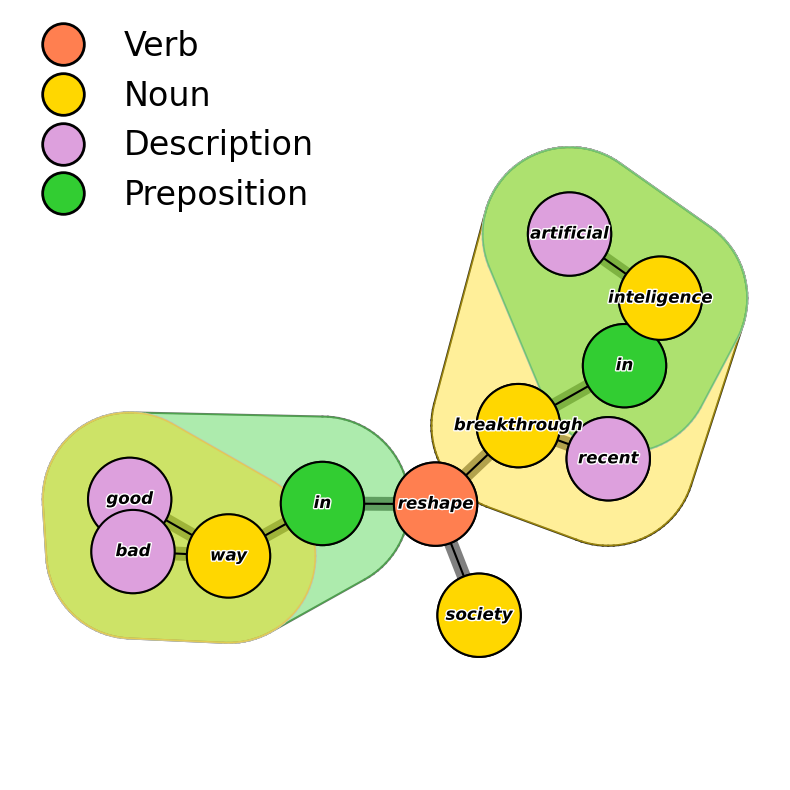

In [5]:
node_cmap = {
    "Verb": "coral",
    "Noun": "gold",
    "Desc": "plum",
    "Prep": "limegreen"
}
labels = {
    "Desc": "Description",
    "Prep": "Preposition"
}
edge_cmap = { k[0]+"P": v for k, v in node_cmap.items() }
kwds = dict(
    node_fc={ n.i: node_cmap[sent.cmap[n.i].alias] for n in H.nodes },
    node_ec="black",
    node_lw=1.5,
    node_size=60,
    edge_fc={ 
        eid: edge_cmap[sent.pmap[eid].alias] for eid in H.edges
        if isinstance(eid, int)
    },
    radius=.3
)
fig, ax = plt.subplots(figsize=(8, 8))
pos = xgi.barycenter_kamada_kawai_layout(H)
xgi.draw(H, pos, **kwds, dyad_color="gray", dyad_lw=10, max_order=1)
xgi.draw_hypergraph_hull(H, pos, **kwds, dya_color=None)
txtkw = dict(
    ha="center", va="center", fontweight="bold", size="large",
    fontstyle="oblique", path_effects=[
        PathEffects.withStroke(linewidth=2, foreground="white")
])
for node, xy in pos.items():
    ax.text(*xy, node.lemma, zorder=100, **txtkw)
handles = [
    mpl.lines.Line2D(
        [0], [0], color=node_cmap[comp], lw=0, 
        label=labels.get(comp, comp),
        marker="o", markersize=30, markeredgecolor="black",
        markeredgewidth=2,
    ) for comp in node_cmap
]
fig.legend(
    handles=handles, loc="upper left", ncol=1, frameon=False,
    fontsize=24
)
# fig.supxlabel("Hyperghraph of phrases", fontsize=40)
fig.tight_layout()